# https://github.com/BrandonReyes0609/VP-Lab2.git

Laboratorio 2 Visión por computadora

 - Nancy Mazariegos – 22513 
 - Brandon Reyes – 22992 
 - Santiago Pereira – 22318 

# Task 1

si se quiere hacer efecto rayado a fotografia

In [1]:
import cv2
import numpy as np
import math


ruta_foto = "imagenes\imagen1.jpg"

nuevo_ancho = 512
nuevo_alto = 512

amplitud_ruido = 35.0   
frecuencia_x = 0.03     
frecuencia_y = 0.017    


imagen_gris = cv2.imread(ruta_foto, cv2.IMREAD_GRAYSCALE)
if imagen_gris is None:
    raise FileNotFoundError("No se encontró el archivo 'mi_foto.jpg'")


imagen_redimensionada = cv2.resize(imagen_gris, (nuevo_ancho, nuevo_alto))


alto = imagen_redimensionada.shape[0]
ancho = imagen_redimensionada.shape[1]
imagen_float = imagen_redimensionada.astype(np.float32).copy()
ruido = np.zeros((alto, ancho), dtype=np.float32)


pi_por_dos = 2.0 * math.pi  

i = 0
while i < alto:
    j = 0
    while j < ancho:
        argumento = (frecuencia_x * float(j)) + (frecuencia_y * float(i))
        argumento = pi_por_dos * argumento
        valor_seno = math.sin(argumento)
        valor_ruido = amplitud_ruido * valor_seno
        ruido[i, j] = valor_ruido

        j = j + 1
    i = i + 1


imagen_con_ruido_float = np.zeros((alto, ancho), dtype=np.float32)

i = 0
while i < alto:
    j = 0
    while j < ancho:
        valor_imagen = imagen_float[i, j]
        valor_del_ruido = ruido[i, j]
        suma = valor_imagen + valor_del_ruido
        imagen_con_ruido_float[i, j] = suma

        j = j + 1
    i = i + 1


imagen_con_ruido_uint8 = np.zeros((alto, ancho), dtype=np.uint8)

i = 0
while i < alto:
    j = 0
    while j < ancho:
        valor = imagen_con_ruido_float[i, j]

        if valor < 0.0:
            valor = 0.0

        if valor > 255.0:
            valor = 255.0

        imagen_con_ruido_uint8[i, j] = int(valor)

        j = j + 1
    i = i + 1


nombre_salida = "periodic_noise.jpg"
guardado_ok = cv2.imwrite(nombre_salida, imagen_con_ruido_uint8)

if guardado_ok:
    print("Imagen generada y guardada como periodic_noise.jpg")
else:
    print("Ocurrió un problema al guardar la imagen de salida")


<>:6: SyntaxWarning: invalid escape sequence '\i'
<>:6: SyntaxWarning: invalid escape sequence '\i'
C:\Users\brand\AppData\Local\Temp\ipykernel_24036\1492616495.py:6: SyntaxWarning: invalid escape sequence '\i'
  ruta_foto = "imagenes\imagen1.jpg"


Imagen generada y guardada como periodic_noise.jpg


### Codigo para la task 1

Tamaño de la imagen: 512x512
Media (sin DC): 8.25366199517557
Desviación (sin DC): 0.8993889896580939
Umbral para picos: 10.95182896414985
Candidatos encontrados: 2152
Picos seleccionados: 8


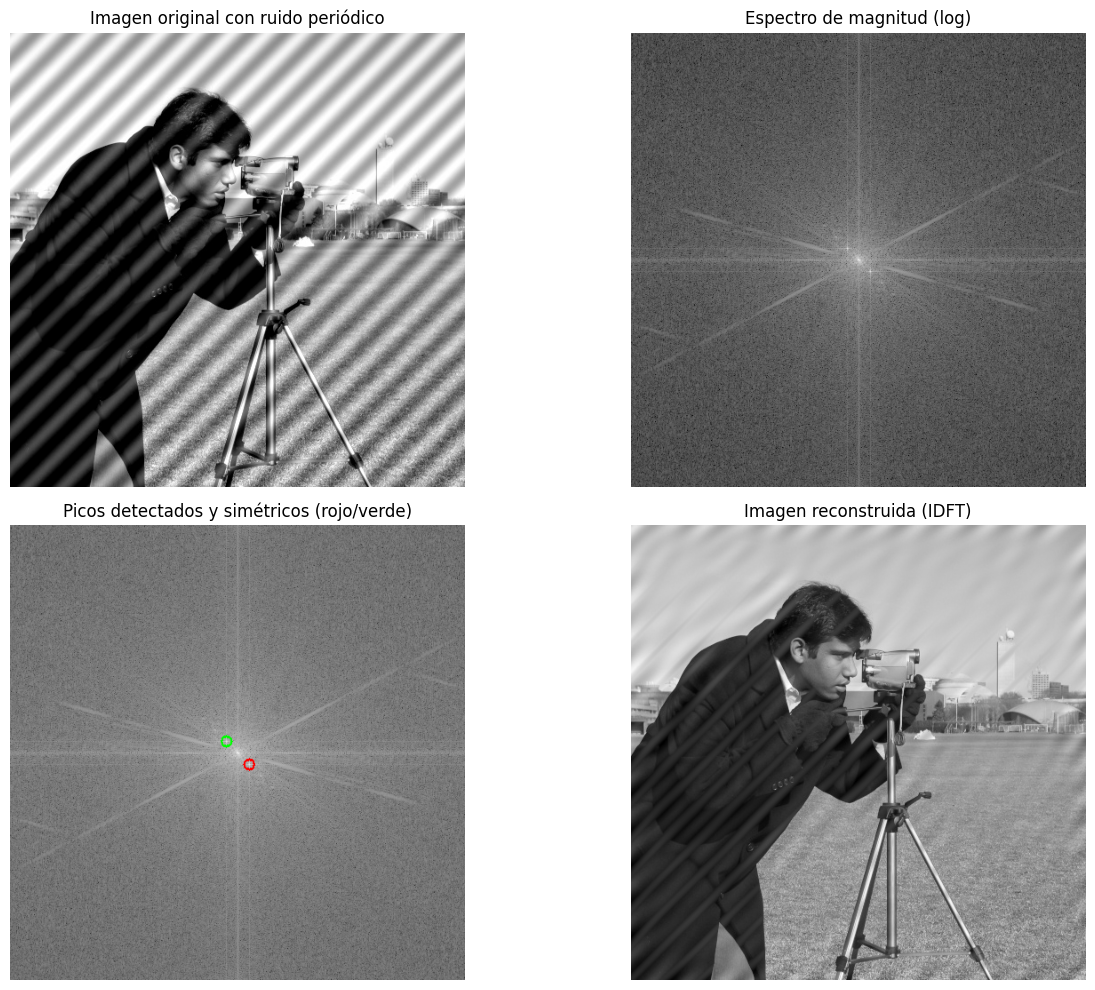

Archivos guardados:
 - resultado_task1_espectro_log.png
 - resultado_task1_picos_marcados.png
 - resultado_task1_reconstruida.png


In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt


ruta_imagen = "imagenes/periodic_noise.jpg"  

radio_dc_exclusion = 15   
k_veces_desviacion = 3.0  
cantidad_picos = 8       
radio_notch = 6           


img = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError("No se encontró 'periodic_noise.jpg'")

img_float = img.astype(np.float32)

alto = img.shape[0]
ancho = img.shape[1]

print("Tamaño de la imagen: " + str(ancho) + "x" + str(alto))


fft2 = np.fft.fft2(img_float)      
fft2_shift = np.fft.fftshift(fft2) 
 

magnitud = np.abs(fft2_shift)
magnitud_log = np.log(1.0 + magnitud)  

cy = int(alto / 2)
cx = int(ancho / 2)

suma = 0.0
suma_cuadrados = 0.0
contador = 0

i = 0
while i < alto:
    j = 0
    while j < ancho:
        dy = i - cy
        dx = j - cx
        distancia2 = (dy * dy) + (dx * dx)

        if distancia2 > (radio_dc_exclusion * radio_dc_exclusion):
            valor = float(magnitud_log[i, j])
            suma = suma + valor
            suma_cuadrados = suma_cuadrados + (valor * valor)
            contador = contador + 1
        j = j + 1
    i = i + 1

if contador == 0:
    raise ValueError("No se pudo calcular media/std (contador=0)")

media = suma / float(contador)
varianza = (suma_cuadrados / float(contador)) - (media * media)
if varianza < 0.0:
    varianza = 0.0
desviacion = math.sqrt(varianza)

umbral = media + (k_veces_desviacion * desviacion)

print("Media (sin DC): " + str(media))
print("Desviación (sin DC): " + str(desviacion))
print("Umbral para picos: " + str(umbral))

candidatos = []  

i = 0
while i < alto:
    j = 0
    while j < ancho:
        dy = i - cy
        dx = j - cx
        distancia2 = (dy * dy) + (dx * dx)

        if distancia2 > (radio_dc_exclusion * radio_dc_exclusion):
            valor = float(magnitud_log[i, j])
            if valor > umbral:
                distancia = math.sqrt(float(distancia2))
                # Guardamos para luego ordenar/filtrar
                candidatos.append((valor, i, j, distancia))
        j = j + 1
    i = i + 1

print("Candidatos encontrados: " + str(len(candidatos)))

candidatos_ordenados = sorted(candidatos, key=lambda t: (t[0], t[3]), reverse=True)

picos_seleccionados = []
indice = 0
while indice < len(candidatos_ordenados) and indice < cantidad_picos:
    picos_seleccionados.append(candidatos_ordenados[indice])
    indice = indice + 1

print("Picos seleccionados: " + str(len(picos_seleccionados)))

mask = np.ones((alto, ancho), dtype=np.float32)

def anular_circulo_en_mascara(mascara, centro_x, centro_y, radio):
    i = 0
    while i < mascara.shape[0]:
        j = 0
        while j < mascara.shape[1]:
            dy = i - centro_y
            dx = j - centro_x
            dist2 = (dy * dy) + (dx * dx)
            if dist2 <= (radio * radio):
                mascara[i, j] = 0.0
            j = j + 1
        i = i + 1


magnitude_log_norm = magnitud_log / magnitud_log.max()
magnitude_log_uint8 = (magnitude_log_norm * 255.0).astype(np.uint8)
espectro_bgr = cv2.cvtColor(magnitude_log_uint8, cv2.COLOR_GRAY2BGR)

idx = 0
while idx < len(picos_seleccionados):
    valor_log, py, px, dist = picos_seleccionados[idx]

    dy = py - cy
    dx = px - cx
    if (dy * dy) + (dx * dx) <= (radio_dc_exclusion * radio_dc_exclusion):
        idx = idx + 1
        continue

    anular_circulo_en_mascara(mask, px, py, radio_notch)

    sx = (2 * cx) - px
    sy = (2 * cy) - py
    anular_circulo_en_mascara(mask, sx, sy, radio_notch)

    cv2.circle(espectro_bgr, (px, py), radio_notch, (0, 0, 255), 1)  # rojo
    cv2.circle(espectro_bgr, (sx, sy), radio_notch, (0, 255, 0), 1)  # verde

    idx = idx + 1

i = 0
while i < alto:
    j = 0
    while j < ancho:
        dy = i - cy
        dx = j - cx
        dist2 = (dy * dy) + (dx * dx)
        if dist2 <= (radio_dc_exclusion * radio_dc_exclusion):
            mask[i, j] = 1.0
        j = j + 1
    i = i + 1


fft2_filtrado = fft2_shift * mask
fft2_ishift = np.fft.ifftshift(fft2_filtrado)
img_rec_complex = np.fft.ifft2(fft2_ishift)
img_rec_real = np.real(img_rec_complex)

min_val = float(img_rec_real.min())
max_val = float(img_rec_real.max())
rango = max_val - min_val
if rango == 0.0:
    rango = 1.0

img_rec_norm = np.zeros((alto, ancho), dtype=np.float32)

i = 0
while i < alto:
    j = 0
    while j < ancho:
        valor = float(img_rec_real[i, j])
        valor = (valor - min_val) / rango
        if valor < 0.0:
            valor = 0.0
        if valor > 1.0:
            valor = 1.0
        img_rec_norm[i, j] = valor
        j = j + 1
    i = i + 1

img_rec_uint8 = (img_rec_norm * 255.0).astype(np.uint8)

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("Imagen original con ruido periódico")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(magnitud_log, cmap="gray")
plt.title("Espectro de magnitud (log)")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(espectro_bgr, cv2.COLOR_BGR2RGB))
plt.title("Picos detectados y simétricos (rojo/verde)")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(img_rec_uint8, cmap="gray")
plt.title("Imagen reconstruida (IDFT)")
plt.axis("off")

plt.tight_layout()
plt.show()

cv2.imwrite("resultado_task1_espectro_log.png", (magnitud_log / magnitud_log.max() * 255.0).astype(np.uint8))
cv2.imwrite("resultado_task1_picos_marcados.png", espectro_bgr)
cv2.imwrite("resultado_task1_reconstruida.png", img_rec_uint8)

print("Archivos guardados:")
print(" - resultado_task1_espectro_log.png")
print(" - resultado_task1_picos_marcados.png")
print(" - resultado_task1_reconstruida.png")


Un filto promedio de 5x5 es atenuado de forma global todas las frecuacnias maximas y por eso se elimina dettalles sin eliminar de forma eficiente el ruido, que está centrado en frecuencias muy especificas y orientado. En cambio el filtro notch en el dominio de Fourrier suprime solo las frecuencia del ruido y preserva el resto de la información, asi mismo logra una restauración más limpia.

## Task 2

In [1]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

img_original = cv2.imread('./lab2/fingerprint_noisy.png', cv2.IMREAD_GRAYSCALE)

if img_original is None:
    print("ERROR: No se pudo cargar la imagen. Verifica la ruta.")
else:
    _, img_binary = cv2.threshold(img_original, 127, 255, cv2.THRESH_BINARY)
    
    print(f"Dimensiones: {img_binary.shape}")
    print(f"Valores únicos: {np.unique(img_binary)}")


Dimensiones: (512, 512)
Valores únicos: [  0 255]


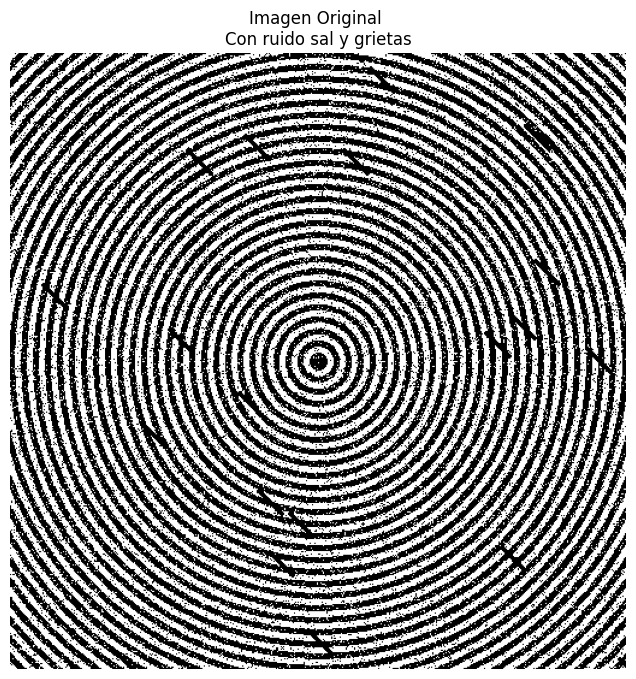

Elemento Estructurante RECTÁNGULO 5x5:
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]

Elemento Estructurante CRUZ 5x5:
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]

Elemento Estructurante ELIPSE 5x5:
[[0 0 1 0 0]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [0 0 1 0 0]]


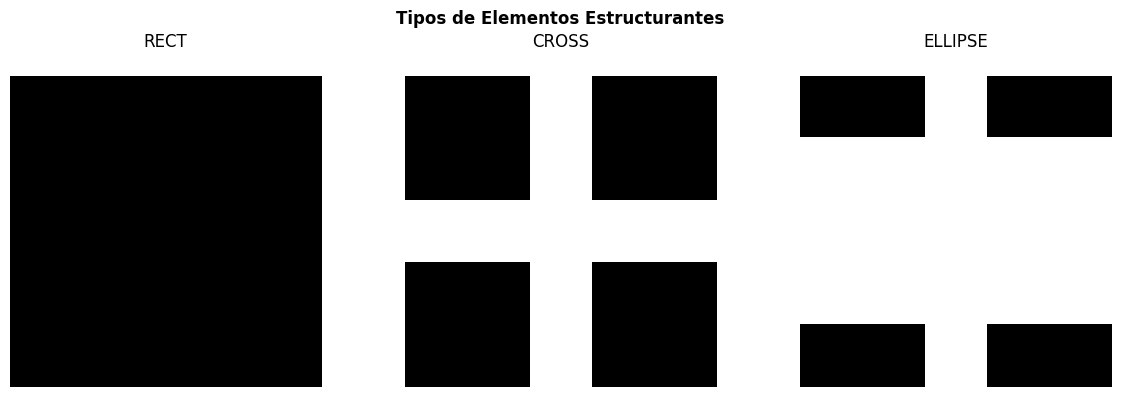

Elemento Estructurante para APERTURA:
Forma: Elipse
Tamaño: 3x3
Matriz:
[[0 1 0]
 [1 1 1]
 [0 1 0]]

Píxeles de ruido eliminados: 17940


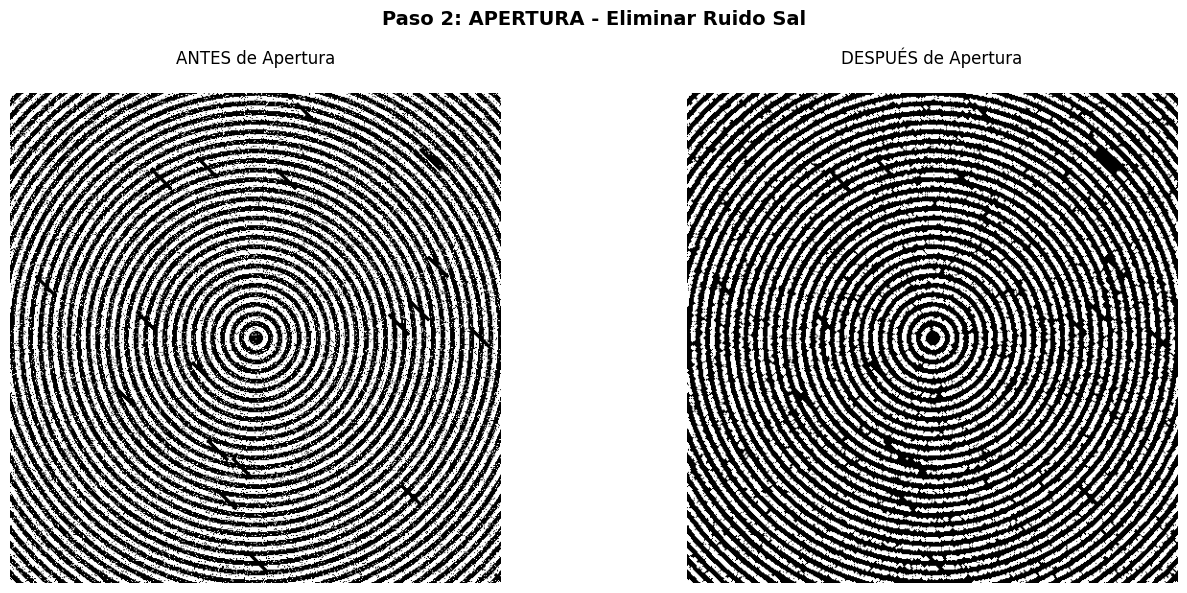

In [5]:
plt.figure(figsize=(8, 8))
plt.imshow(img_binary, cmap='gray')
plt.title('Imagen Original \nCon ruido sal y grietas')
plt.axis('off')
plt.show()

se_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
se_cross = cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))
se_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

print("Elemento Estructurante RECTÁNGULO 5x5:")
print(se_rect)
print("\nElemento Estructurante CRUZ 5x5:")
print(se_cross)
print("\nElemento Estructurante ELIPSE 5x5:")
print(se_ellipse)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(se_rect, cmap='gray')
axes[0].set_title('RECT\n')
axes[1].imshow(se_cross, cmap='gray')
axes[1].set_title('CROSS\n')
axes[2].imshow(se_ellipse, cmap='gray')
axes[2].set_title('ELLIPSE\n')
for ax in axes:
   ax.axis('off')
plt.suptitle('Tipos de Elementos Estructurantes', fontweight='bold')
plt.tight_layout()
plt.show()


se_apertura = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

print("Elemento Estructurante para APERTURA:")
print(f"Forma: Elipse")
print(f"Tamaño: 3x3")
print(f"Matriz:\n{se_apertura}")

img_despues_apertura = cv2.morphologyEx(img_binary, cv2.MORPH_OPEN, se_apertura)

diferencia_apertura = cv2.absdiff(img_binary, img_despues_apertura)
pixeles_eliminados = np.sum(diferencia_apertura > 0)
print(f"\nPíxeles de ruido eliminados: {pixeles_eliminados}")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(img_binary, cmap='gray')
axes[0].set_title('ANTES de Apertura\n', fontsize=12)
axes[0].axis('off')

axes[1].imshow(img_despues_apertura, cmap='gray')
axes[1].set_title('DESPUÉS de Apertura\n', fontsize=12)
axes[1].axis('off')

plt.suptitle('Paso 2: APERTURA - Eliminar Ruido Sal', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()



Elemento Estructurante para CIERRE:
Forma: Elipse
Tamaño: 3x3
Matriz:
[[0 1 0]
 [1 1 1]
 [0 1 0]]

Píxeles de grietas rellenados: 5361


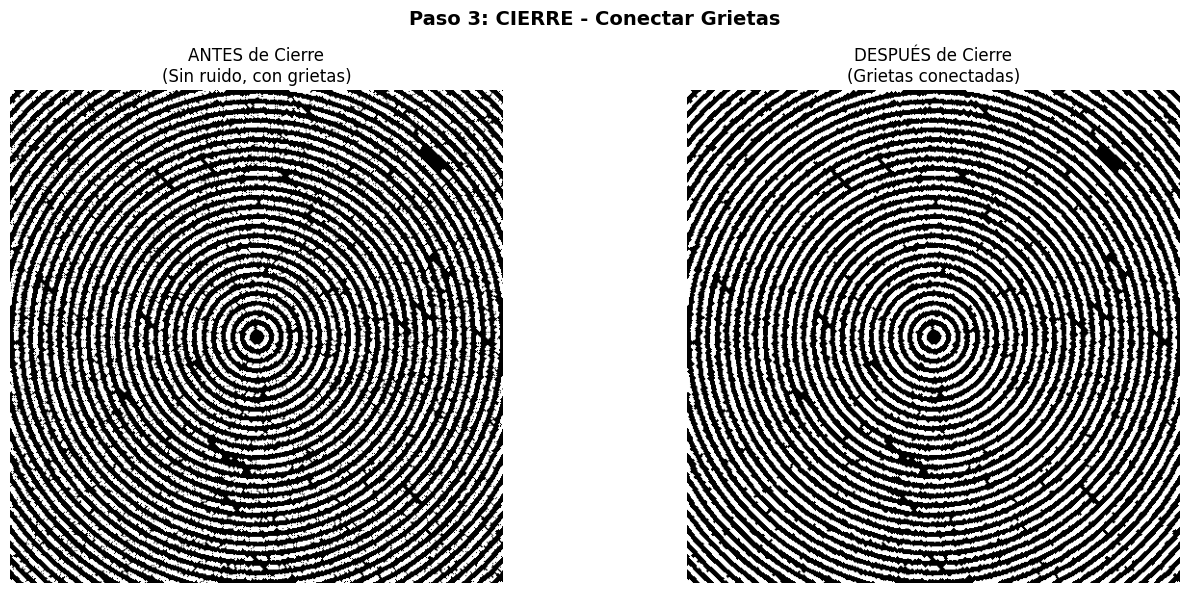

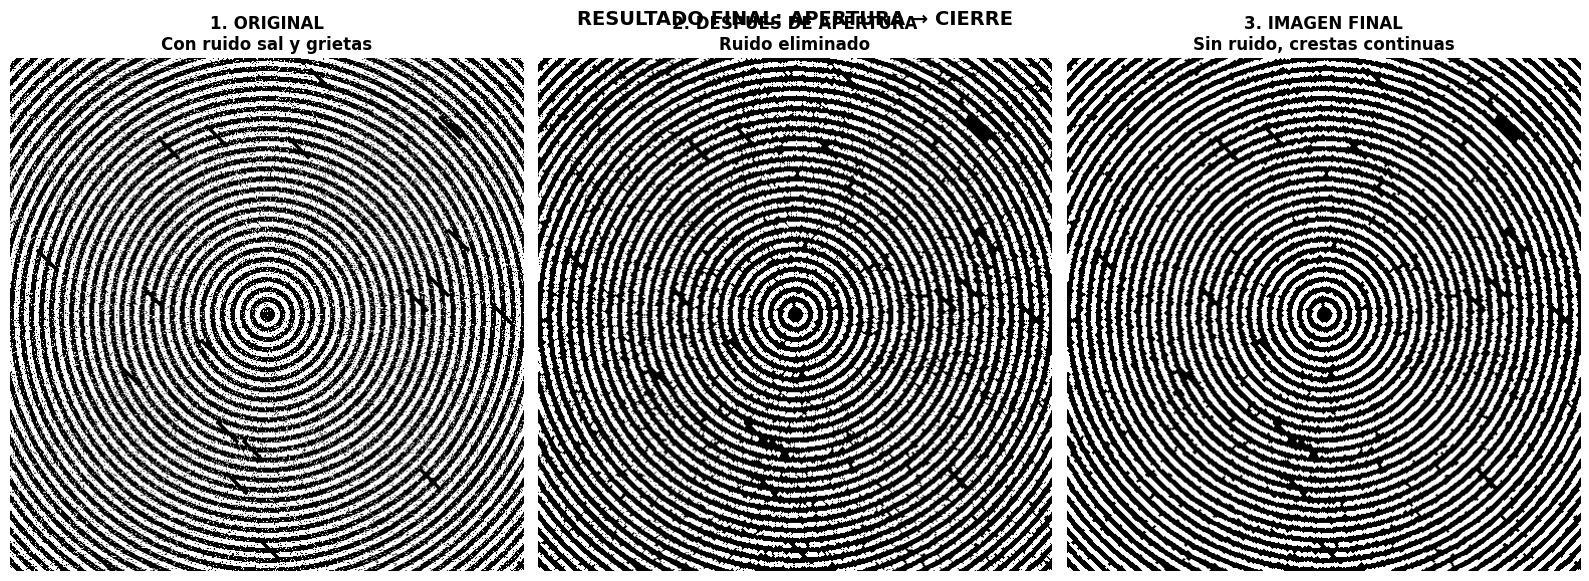

In [ ]:
se_cierre = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

print("Elemento Estructurante para CIERRE:")
print(f"Forma: Elipse")
print(f"Tamaño: 3x3")
print(f"Matriz:\n{se_cierre}")

img_final = cv2.morphologyEx(img_despues_apertura, cv2.MORPH_CLOSE, se_cierre)

diferencia_cierre = cv2.absdiff(img_despues_apertura, img_final)
pixeles_rellenados = np.sum(diferencia_cierre > 0)
print(f"\nPíxeles de grietas rellenados: {pixeles_rellenados}")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(img_despues_apertura, cmap='gray')
axes[0].set_title('ANTES de Cierre\n', fontsize=12)
axes[0].axis('off')

axes[1].imshow(img_final, cmap='gray')
axes[1].set_title('DESPUÉS de Cierre\n', fontsize=12)
axes[1].axis('off')

plt.suptitle('Paso 3: CIERRE - Conectar Grietas', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(16, 6))  

axes[0].imshow(img_binary, cmap='gray')
axes[0].set_title('1. ORIGINAL\nCon ruido sal y grietas', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(img_despues_apertura, cmap='gray')
axes[1].set_title('2. DESPUÉS DE APERTURA\nRuido eliminado', fontsize=12, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(img_final, cmap='gray')
axes[2].set_title('3. IMAGEN FINAL\nSin ruido, crestas continuas', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.suptitle('RESULTADO FINAL', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Task 3

Una fábrica textil necesita detectar rasgaduras en telas de mezclilla (denim) automáticamente. El problema
es que la tela tiene una textura natural fuerte (patrón repetitivo) que confunde a los detectores de bordes
simples (Canny), detectando el tejido como si fuera un defecto. Por ello se le pide que usted diseñe un
pipeline híbrido que combine Fourier y Morfología para aislar solamente la rasgadura. Para ello comienza
por probar su solución en una imagen que tiene a mano. Con esto en mente, realice:

1. Utilice Fourier para analizar la textura repetitiva de la tela. Diseñe un filtro que elimine las
frecuencias altas/repetitivas del tejido, dejando una imagen "suavizada" donde solo resalte la
anomalía (la rasgadura) y la iluminación global. (Supresión de Textura)

2. Aplique un umbralizado (thresholding) a la imagen resultante del paso 1 para obtener una máscara
binaria preliminar. (Segmentación)

3. La máscara seguramente tendrá ruido residual. Utilice operaciones morfológicas para limpiar la
máscara y dejar únicamente la silueta de la rasgadura. (Refinamiento)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_row(titles, imgs, cmap='gray', figsize=(26,4)):
    n = len(imgs)
    plt.figure(figsize=figsize)
    for i, (t, im) in enumerate(zip(titles, imgs), 1):
        plt.subplot(1, n, i)
        plt.imshow(im, cmap=cmap)
        plt.title(t)
        plt.axis('off')
    plt.show()


### Fourier 

In [2]:
def fft2_shift(img):
    F = np.fft.fft2(img.astype(np.float32))
    return np.fft.fftshift(F)

def ifft2_ishift(Fshift):
    F_ishift = np.fft.ifftshift(Fshift)
    img_back = np.fft.ifft2(F_ishift)
    return np.real(img_back)

def magnitude_spectrum(Fshift):
    mag = np.log1p(np.abs(Fshift))
    mag_norm = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    return mag_norm.astype(np.uint8)

def make_lowpass_mask(shape, radius):
    h, w = shape
    cy, cx = h//2, w//2
    Y, X = np.ogrid[:h, :w]
    dist2 = (Y-cy)**2 + (X-cx)**2
    return (dist2 <= radius**2).astype(np.float32)

def make_notch_mask_from_peaks(mag, peak_percentile=99.7, center_keep_radius=25, notch_radius=6):
    h, w = mag.shape
    cy, cx = h//2, w//2

    ignore = np.zeros((h, w), np.uint8)
    cv2.circle(ignore, (cx, cy), center_keep_radius, 255, -1)

    thresh = np.percentile(mag[ignore == 0], peak_percentile)
    peaks = ((mag >= thresh) & (ignore == 0)).astype(np.uint8) * 255
    peaks = cv2.dilate(peaks, np.ones((3,3), np.uint8), iterations=1)

    notch_mask = np.ones((h, w), np.float32)
    ys, xs = np.where(peaks > 0)
    for (y, x) in zip(ys, xs):
        cv2.circle(notch_mask, (int(x), int(y)), notch_radius, 0, -1)

    cv2.circle(notch_mask, (cx, cy), center_keep_radius, 1, -1)
    return notch_mask, peaks, thresh


In [3]:
def filter_components_by_area(mask, min_area=80, max_area=None):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    out = np.zeros_like(mask)
    if num_labels <= 1:
        return out

    for lab in range(1, num_labels):
        area = stats[lab, cv2.CC_STAT_AREA]
        if area >= min_area and (max_area is None or area <= max_area):
            out[labels == lab] = 255
    return out

def refine_mask_v3(mask0,
                   open_rect=(3,3),
                   close_rect=(21,7),
                   close_iter=2,
                   min_area=120,
                   max_area=5000):
    k_open  = cv2.getStructuringElement(cv2.MORPH_RECT, open_rect)
    k_close = cv2.getStructuringElement(cv2.MORPH_RECT, close_rect)

    m1 = cv2.morphologyEx(mask0, cv2.MORPH_OPEN, k_open, iterations=1)
    m2 = cv2.morphologyEx(m1, cv2.MORPH_CLOSE, k_close, iterations=close_iter)
    m3 = filter_components_by_area(m2, min_area=min_area, max_area=max_area)
    return m3


In [4]:
def pipeline_fourier_morph_fixed(img_gray,
                                 lp_radius=60,
                                 peak_percentile=99.95,
                                 center_keep_radius=25,
                                 notch_radius=4,
                                 max_peaks_ratio=0.0005,   
                                 residual_blur_ksize=5,
                                 tophat_ksize=31,
                                 k_sigma=1.5,
                                 open_rect=(3,3),
                                 close_rect=(21,7),
                                 close_iter=2,
                                 min_area=150,
                                 max_area=4000):

    Fshift = fft2_shift(img_gray)
    mag = magnitude_spectrum(Fshift)

    lp = make_lowpass_mask(img_gray.shape, lp_radius)
    notch, peaks, thr = make_notch_mask_from_peaks(
        mag,
        peak_percentile=peak_percentile,
        center_keep_radius=center_keep_radius,
        notch_radius=notch_radius
    )

    peak_ratio = np.count_nonzero(peaks) / peaks.size
    use_notch = peak_ratio <= max_peaks_ratio
    H = lp * (notch if use_notch else 1.0)

    smooth = ifft2_ishift(Fshift * H)
    smooth_u8 = cv2.normalize(smooth, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    residual = cv2.absdiff(img_gray, smooth_u8)
    if residual_blur_ksize and residual_blur_ksize > 1:
        residual = cv2.GaussianBlur(residual, (residual_blur_ksize, residual_blur_ksize), 0)

    k_th = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (tophat_ksize, tophat_ksize))
    residual_tophat = cv2.morphologyEx(residual, cv2.MORPH_TOPHAT, k_th)

    mu = float(np.mean(residual_tophat))
    sigma = float(np.std(residual_tophat))
    T = mu + k_sigma * sigma

    _, mask0 = cv2.threshold(residual_tophat, T, 255, cv2.THRESH_BINARY)

    final = refine_mask_v3(mask0,
                           open_rect=open_rect,
                           close_rect=close_rect,
                           close_iter=close_iter,
                           min_area=min_area,
                           max_area=max_area)

    debug = {
        "mag": mag,
        "peaks": peaks,
        "smooth": smooth_u8,
        "residual": residual,
        "residual_tophat": residual_tophat,
        "T": T,
        "mask0": mask0,
        "final": final,
        "peak_thr": thr,
        "use_notch": use_notch,
        "peak_ratio": peak_ratio
    }
    return debug



imagenes/periodic_noise.jpg | use_notch=False | peak_ratio=0.009003 | T=12.63


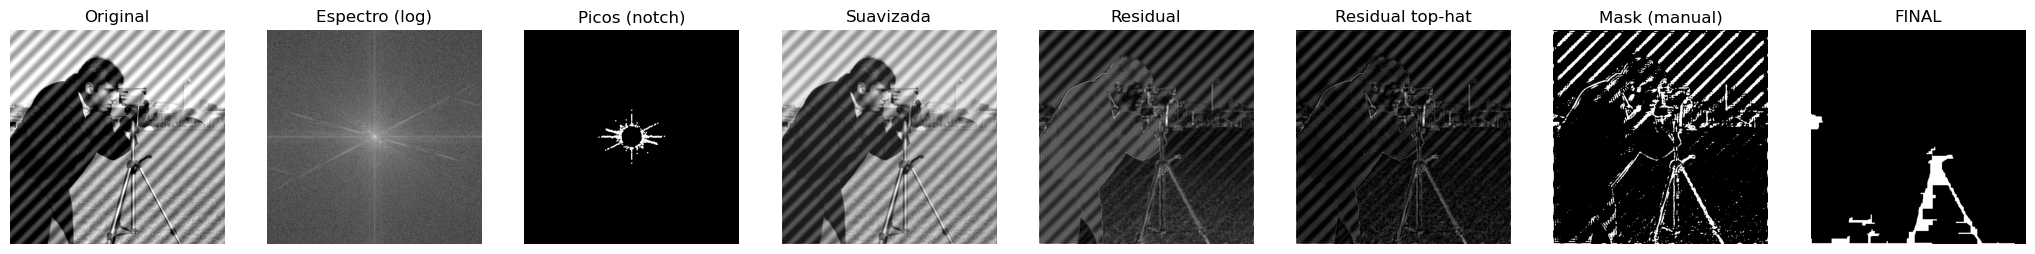


imagenes/fingerprint_noisy.png | use_notch=False | peak_ratio=0.005142 | T=50.74


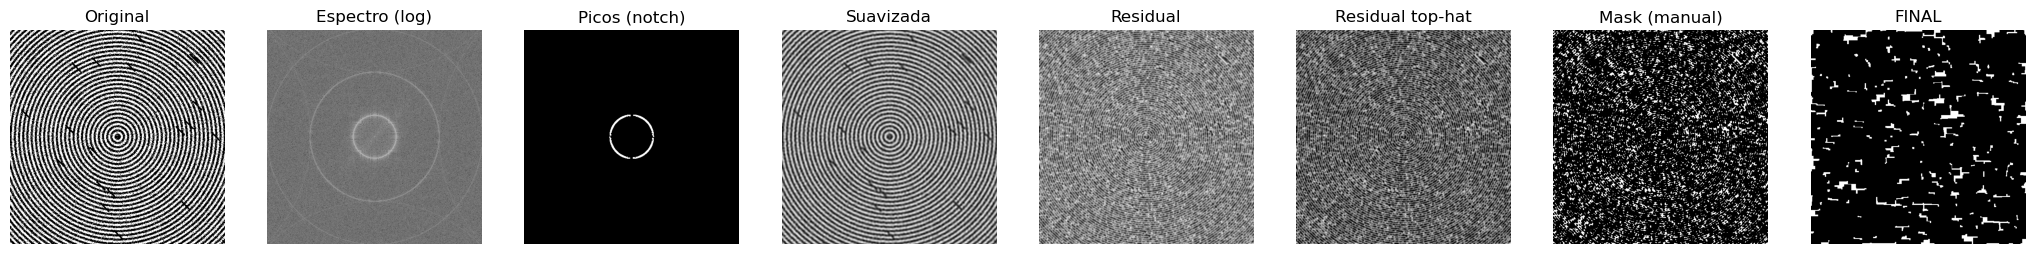


imagenes/textile_defect.jpg | use_notch=False | peak_ratio=0.007488 | T=47.22


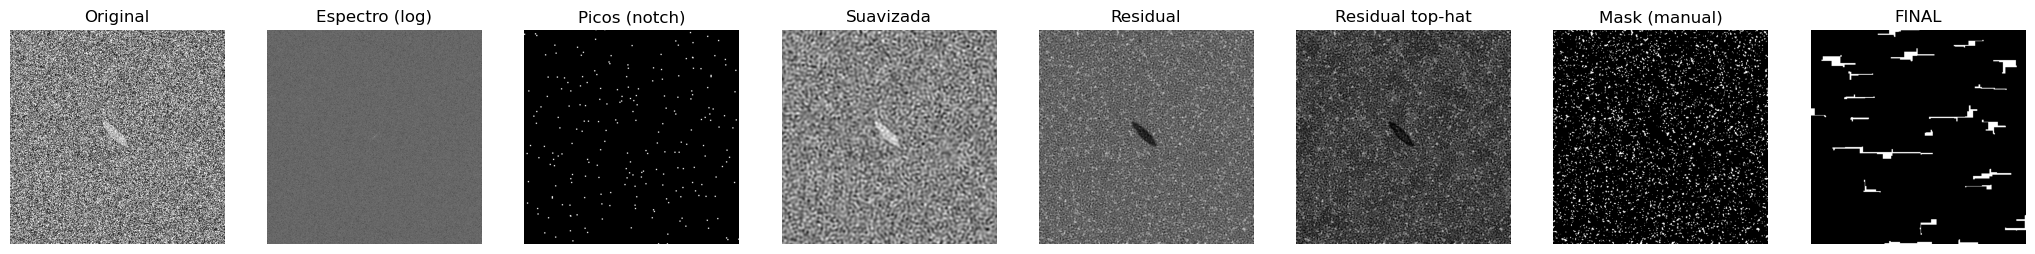

In [5]:
paths = [
    "imagenes/periodic_noise.jpg",
    "imagenes/fingerprint_noisy.png",
    "imagenes/textile_defect.jpg"
]

per_image = {
    "imagenes/periodic_noise.jpg": dict(
        lp_radius=90, peak_percentile=99.8, notch_radius=8,
        tophat_ksize=21, k_sigma=1.2,
        close_rect=(17,7), min_area=300, max_area=20000
    ),
    "imagenes/fingerprint_noisy.png": dict(
        lp_radius=80, peak_percentile=99.85, notch_radius=6,
        tophat_ksize=25, k_sigma=1.0,
        close_rect=(9,5), min_area=20, max_area=800
    ),
    "imagenes/textile_defect.jpg": dict(
        lp_radius=60, peak_percentile=99.95, notch_radius=4,
        max_peaks_ratio=0.0005,
        tophat_ksize=31, k_sigma=1.5,
        close_rect=(21,7), min_area=150, max_area=4000
    )
}

for p in paths:
    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"No pude cargar: {p}")
        continue

    dbg = pipeline_fourier_morph_fixed(img, **per_image.get(p, {}))

    print(f"\n{p} | use_notch={dbg['use_notch']} | peak_ratio={dbg['peak_ratio']:.6f} | T={dbg['T']:.2f}")

    show_row(
        ["Original", "Espectro (log)", "Picos (notch)", "Suavizada", "Residual", "Residual top-hat", "Mask (manual)", "FINAL"],
        [img, dbg["mag"], dbg["peaks"], dbg["smooth"], dbg["residual"], dbg["residual_tophat"], dbg["mask0"], dbg["final"]],
        figsize=(26,4)
    )


#### Conclusión

La solución utiliza Fourier y operaciones morfológicas para detectar rasgaduras en telas con textura fuerte. El filtrado en el dominio de la frecuencia ayuda a eliminar los patrones repetitivos del tejido, dejando una imagen más suave donde el defecto resalta mejor. Sin embargo, existe un compromiso importante: si la rasgadura es muy pequeña o poco visible, puede eliminarse junto con la textura durante el filtrado o la limpieza morfológica. Además, si se cambia el tipo de tela, el patrón de textura también cambia, por lo que es necesario ajustar los parámetros del filtro y del umbral. Por ello, la solución es efectiva para defectos claros, pero no totalmente general sin ajustes.